In [37]:
from astropy.io import fits
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tempfile
import imageio
from scipy import signal
from importlib import reload
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pylab as pl
# super special:
import sparkles.spark as spkl
import sparkles.spark_plots as sp
lab_dir = '/home/eden/data/LAB_2023B/'

In [38]:
reload(spkl)

<module 'sparkles.spark' from '/home/eden/code/sparkles/sparkles/spark.py'>

In [8]:
# Using a mask:
dir_calib = '/home/eden/data/calib/'
file_mask = 'aol1_wfsmask.fits'
mask_data = fits.open(dir_calib + file_mask)[0].data

In [6]:
from multiprocessing import Pool
from functools import partial
from math import ceil

def phot_count_pool(f_dir, chunk_size, n_chunks, n_start=0, n_workers=4):
    """ dot files in chunks, in parallelism """
    f_list = np.array(spkl.file_lister(f_dir)) # just for checking length
    # check the end number 
    # number of tasks to execute
    n_end = n_start + chunk_size*4*n_chunks
    n_tasks = int((n_end - n_start) / (chunk_size*4))
    print(f"processing from file {n_start} to {n_end}, Chunk size {chunk_size*4} for {n_tasks} tasks")
    #creating the list of n_starts
    n_start_list = [n_start + n*chunk_size*4 for n in range(n_tasks)]
    # create the multiprocessing pool
    with Pool(processes=n_workers) as pool:
        # chunksize to use
        n_tasks_per_chunk = ceil(n_tasks / len(pool._pool))
        # report details for reference
        print(f'chunksize={n_tasks_per_chunk}, n_workers={len(pool._pool)}')
        # issue tasks and process results
        results = pool.map(partial(phot_file_chunk, files=f_list, path=f_dir, n=chunk_size*4), n_start_list, chunksize=n_tasks_per_chunk)
    # return the dot products:
    dot_results = results
    return dot_results

def phot_file_chunk(n_start, files, path, n):
    f_avg_list = []
    f_sum_list = []
    f_wrt_list = []
    f_acq_list = []
    for file in files[n_start: n+n_start]:
        with fits.open(path + file) as hdul:
            f_data = hdul[0].data
            wrt = hdul[0].header['WRTSEC'] + hdul[0].header['WRTNSEC']*10**(-9)
            acq = hdul[0].header['ACQSEC'] + hdul[0].header['ACQNSEC']*10**(-9)
            f_data_masked = f_data*mask_data
            f_avg_list.append(np.mean(f_data_masked))
            f_sum_list.append(np.sum(f_data_masked))
            f_wrt_list.append(wrt)
            f_acq_list.append(acq)
    return f_avg_list, f_sum_list, f_wrt_list, f_acq_list

In [9]:
def pull_data(f_dir, n_files):
    list_data = []
    list_wrt = []
    list_acq = []

    file_list = spkl.file_lister(f_dir)
    # go through all the files
    print(f"{len(file_list)} files in Directory {f_dir}, proc {n_files}")

    for e, f in enumerate(file_list[:n_files]):
        with fits.open(f_dir + f) as hdul:
            f_data = hdul[0].data
            wrt = hdul[0].header['WRTSEC'] + hdul[0].header['WRTNSEC']*10**(-9)
            acq = hdul[0].header['ACQSEC'] + hdul[0].header['ACQNSEC']*10**(-9)
            f_data_masked = f_data*mask_data
            # I think its quicker to build a big image file and then calculate on it afterwords
            list_data.append(f_data_masked)
            list_acq.append(wrt)
            list_wrt.append(acq)
        if e%1000 == 0:
            print(f"On file {e} of {len(file_list[:n_files])}")

    list_data = np.array(list_data)
    list_acq = np.array(list_acq)
    list_wrt = np.array(list_wrt)

    return list_data, list_acq, list_wrt


## 1/25 checking Duty Cycle

In [39]:
# Duty cycle files
d_cycle_dir = lab_dir + 'duty_cycle_tests/'
# first directory is darks, seconds are open
d_cycle_300 = [d_cycle_dir + 'sync_300pwdth_a/camwfs/', d_cycle_dir + 'sync_300pwdth_b/camwfs/']
d_cycle_250 = [d_cycle_dir + 'sync_darks_250pwdth_a/camwfs/', d_cycle_dir + 'sync_darks_250pwdth_b/camwfs/'] # these are both darks, only one synched
d_cycle_245 = [d_cycle_dir + 'sync_245pwdth_a/camwfs/', d_cycle_dir + 'sync_245pwdth_b/camwfs/']
d_cycle_200 = [d_cycle_dir + 'sync_200pwdth_a/camwfs/', d_cycle_dir + 'sync_200pwdth_b/camwfs/']
n_files = 1000

In [40]:
cycle_300 = [pull_data(d_cycle_300[0], n_files), pull_data(d_cycle_300[1], n_files)]
cycle_250 = [pull_data(d_cycle_250[0], n_files), pull_data(d_cycle_250[1], n_files)]
cycle_245 = [pull_data(d_cycle_245[0], n_files), pull_data(d_cycle_245[1], n_files)]
cycle_200 = [pull_data(d_cycle_200[0], n_files), pull_data(d_cycle_200[1], n_files)]

99612 files in Directory /home/eden/data/LAB_2023B/duty_cycle_tests/sync_300pwdth_a/camwfs/, proc 1000
On file 0 of 1000
276595 files in Directory /home/eden/data/LAB_2023B/duty_cycle_tests/sync_300pwdth_b/camwfs/, proc 1000
On file 0 of 1000
129163 files in Directory /home/eden/data/LAB_2023B/duty_cycle_tests/sync_darks_250pwdth_a/camwfs/, proc 1000
On file 0 of 1000
83424 files in Directory /home/eden/data/LAB_2023B/duty_cycle_tests/sync_darks_250pwdth_b/camwfs/, proc 1000
On file 0 of 1000
36700 files in Directory /home/eden/data/LAB_2023B/duty_cycle_tests/sync_245pwdth_a/camwfs/, proc 1000
On file 0 of 1000
101004 files in Directory /home/eden/data/LAB_2023B/duty_cycle_tests/sync_245pwdth_b/camwfs/, proc 1000
On file 0 of 1000
102023 files in Directory /home/eden/data/LAB_2023B/duty_cycle_tests/sync_200pwdth_a/camwfs/, proc 1000
On file 0 of 1000
119842 files in Directory /home/eden/data/LAB_2023B/duty_cycle_tests/sync_200pwdth_b/camwfs/, proc 1000
On file 0 of 1000


In [41]:
# covert x axis from frames to seconds
hz = 2000
total_s = 4*n_files/hz
x_axis = np.arange(0, total_s, total_s/n_files)

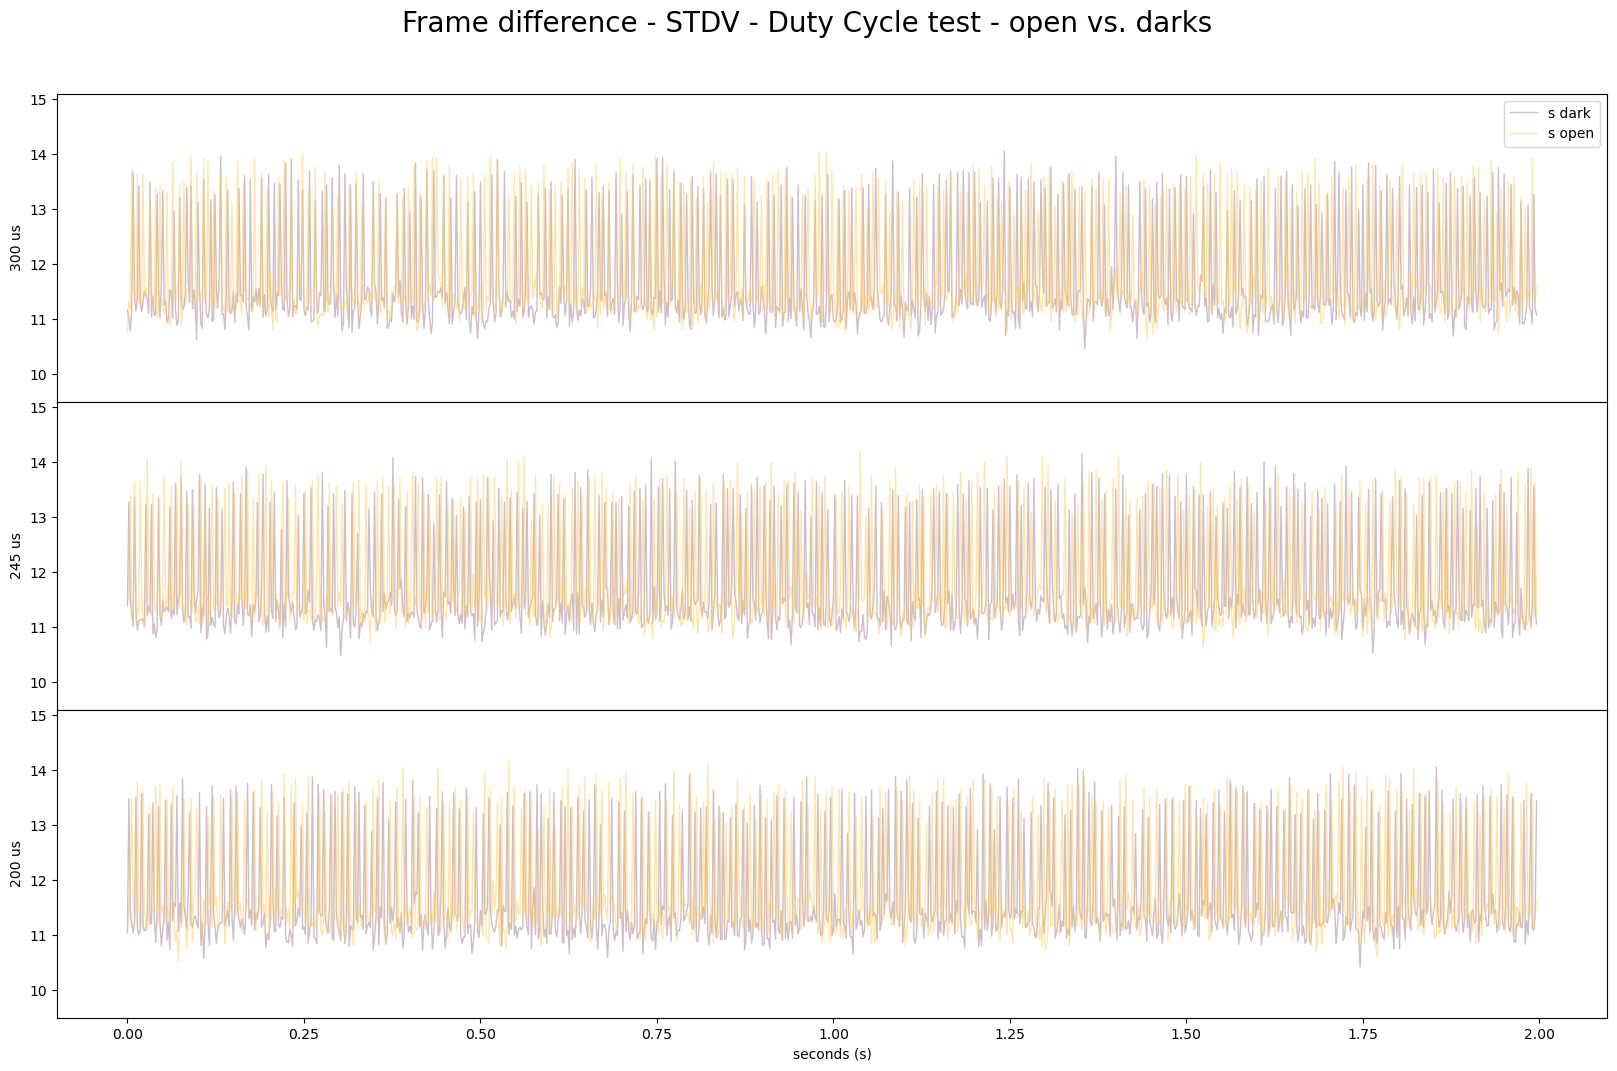

In [48]:
# Pulse Width testing

# Plotting the time series
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,12), facecolor='white', sharex=True)
fig.suptitle("Frame difference - STDV - Duty Cycle test - open vs. darks", y = 0.95, fontsize=20)
fig.subplots_adjust(wspace=0, hspace = 0)
c_open = '#ffcc5c'
c_dark = '#a17c95'

# 300 width
axs[0].set_ylabel("300 us")
axs[0].plot(x_axis[:-1], np.std(np.diff(np.array(cycle_300[0][0]), axis = 0), axis = (1,2)), linewidth=1.0, c=c_dark, alpha=0.5, label = 's dark')
axs[0].plot(x_axis[:-1], np.std(np.diff(np.array(cycle_300[1][0]), axis = 0), axis = (1,2)), linewidth=1.0, c=c_open, alpha=0.5, label = 's open')
axs[0].legend()
#245 us
axs[1].set_ylabel("245 us")
axs[1].plot(x_axis[:-1], np.std(np.diff(np.array(cycle_245[0][0]), axis = 0), axis = (1,2)), linewidth=1.0, c=c_dark, alpha = 0.5)
axs[1].plot(x_axis[:-1], np.std(np.diff(np.array(cycle_245[1][0]), axis = 0), axis = (1,2)), linewidth=1.0, c=c_open, alpha = 0.5)
#200 us 
axs[2].set_ylabel("200 us")
axs[2].plot(x_axis[:-1], np.std(np.diff(np.array(cycle_200[0][0]), axis = 0), axis = (1,2)), linewidth=1.0, c=c_dark, alpha = 0.5)
axs[2].plot(x_axis[:-1], np.std(np.diff(np.array(cycle_200[1][0]), axis = 0), axis = (1,2)), linewidth=1.0, c=c_open, alpha = 0.5)

axs[0].set_ylim(bottom=9.5, top=15.1)
axs[1].set_ylim(bottom=9.5, top=15.1)
axs[2].set_ylim(bottom=9.5, top=15.1)

plt.xlabel('seconds (s)')
plt.show()

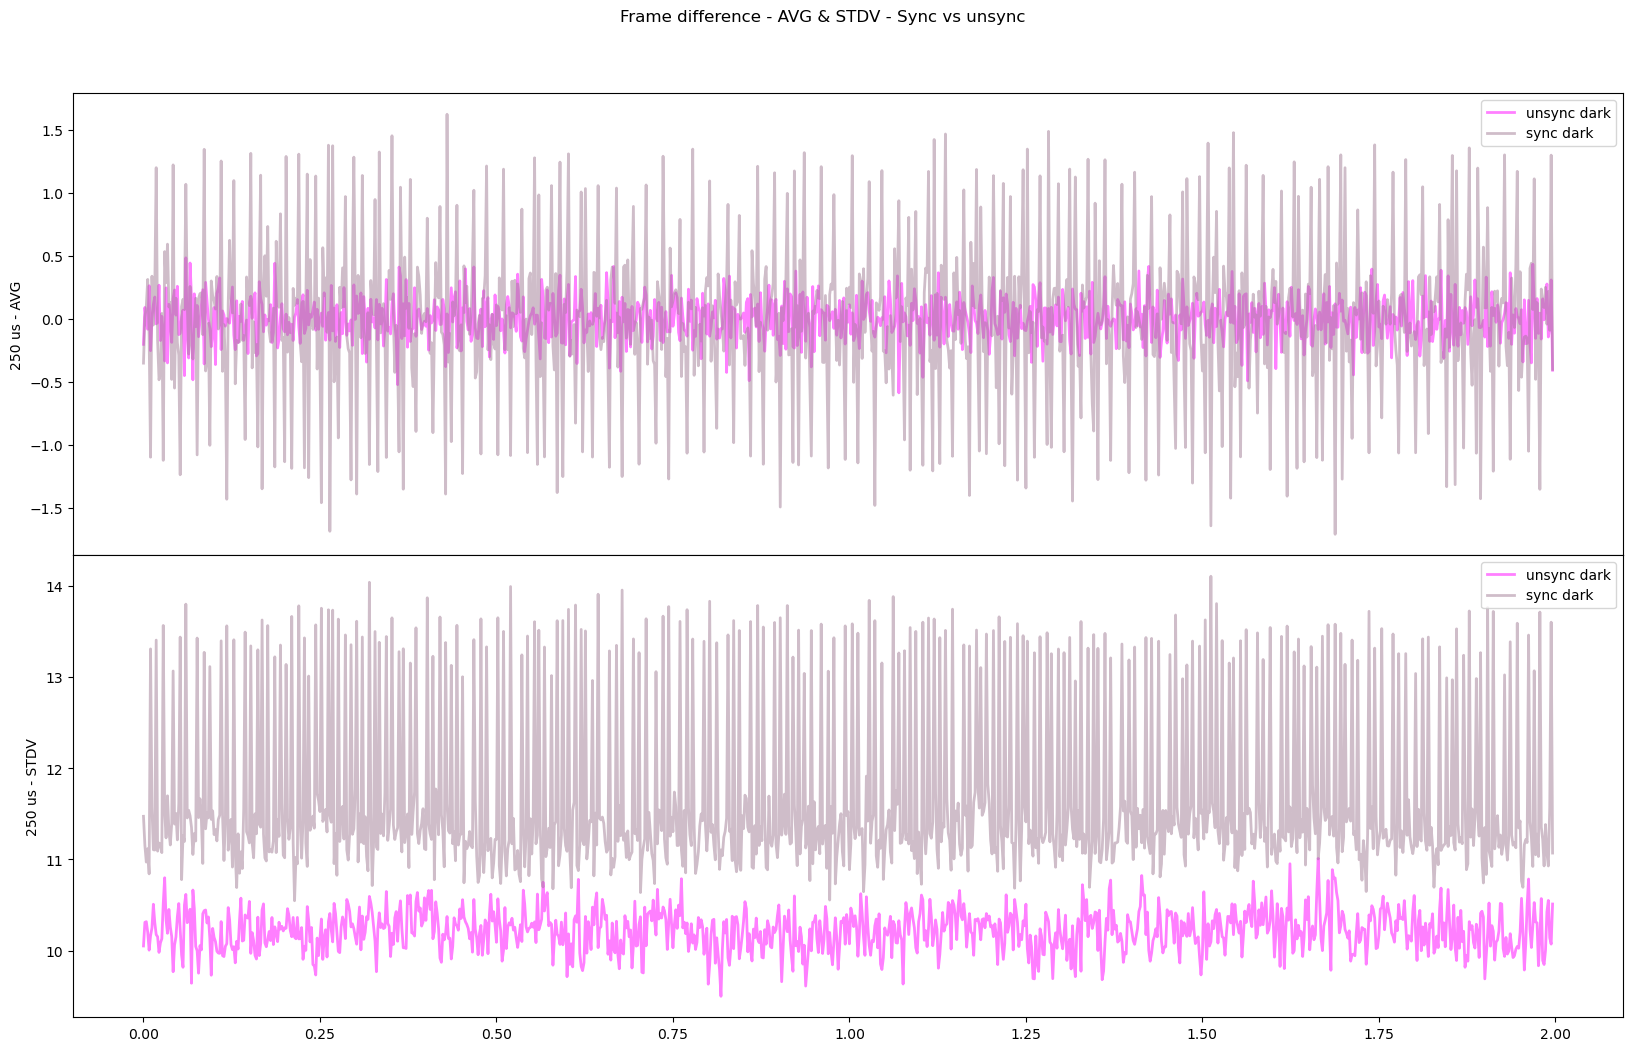

In [52]:
#Zoom in on the previous use case:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,12), facecolor='white', sharex=True)
fig.suptitle("Frame difference - AVG & STDV - Sync vs unsync", y = 0.95)
fig.subplots_adjust(wspace=0, hspace = 0)
c_open = '#ffcc5c'
c_dark = '#a17c95'
axs[0].set_ylabel("250 us - AVG")
axs[0].plot(x_axis[:-1], np.mean(np.diff(np.array(cycle_250[0][0]), axis = 0), axis = (1,2)), linewidth=2.0, c='magenta', alpha = 0.5,label = 'unsync dark')
axs[0].plot(x_axis[:-1], np.mean(np.diff(np.array(cycle_250[1][0]), axis = 0), axis = (1,2)), linewidth=2.0, c=c_dark, alpha = 0.5,label = 'sync dark')
axs[0].legend()

axs[1].set_ylabel("250 us - STDV")
axs[1].plot(x_axis[:-1], np.std(np.diff(np.array(cycle_250[0][0]), axis = 0), axis = (1,2)), linewidth=2.0, c='magenta', alpha = 0.5,label = 'unsync dark')
axs[1].plot(x_axis[:-1], np.std(np.diff(np.array(cycle_250[1][0]), axis = 0), axis = (1,2)), linewidth=2.0, c=c_dark, alpha = 0.5,label = 'sync dark')
axs[1].legend()

## Checking STDV between frames, intra frames

I don't have a up-to-date dark for this configuration and exposure time, so... not gonna use it


In [24]:
# List the photometry files we'll be using
sync_phot_n = "2024-01-17_224857_sync_photometry_ND"
sync_phot_dir = lab_dir + sync_phot_n + "/camwfs/"
unsync_phot_n = "2024-01-17_223727_unsync_photometry_ND"
unsync_phot_dir = lab_dir + unsync_phot_n + "/camwfs/"
n_files = 1000

In [10]:
unsync_data, unsync_acq, unsync_wrt = pull_data(unsync_phot_dir, n_files)

429365 files in Directory /home/eden/data/LAB_2023B/2024-01-17_223727_unsync_photometry_ND/camwfs/, proc 1000
On file 0 of 1000


In [19]:
# Differences: shift one differences
unsync_data_diff = np.diff(unsync_data, axis = 0)
unsync_wrt_diff = np.diff(unsync_wrt)
unsync_acq_diff = np.diff(unsync_acq)
# doing the calc
unsync_f_avg = np.mean(unsync_data, axis = (1,2)) # average value in frame
unsync_f_std = np.std(unsync_data, axis = (1,2)) # sdv of pixels across frame
# on 
unsync_d_avg = np.mean(unsync_data_diff, axis=(1,2)) # average difference btween pixels frame to frame
unsync_d_std = np.std(unsync_data_diff, axis=(1,2)) # sdv on difference between images

In [17]:
sync_data, sync_acq, sync_wrt = pull_data(sync_phot_dir, n_files)

607038 files in Directory /home/eden/data/LAB_2023B/2024-01-17_224857_sync_photometry_ND/camwfs/, proc 1000
On file 0 of 1000


In [23]:
# Differences: shift one differences
sync_data_diff = np.diff(sync_data, axis = 0)
sync_wrt_diff = np.diff(sync_wrt)
sync_acq_diff = np.diff(sync_acq)
# doing the calc
sync_f_avg = np.mean(sync_data, axis = (1,2)) # average value in frame
sync_f_std = np.std(sync_data, axis = (1,2)) # sdv of pixels across frame
# on 
sync_d_avg = np.mean(sync_data_diff, axis=(1,2)) # average difference btween pixels frame to frame
sync_d_std = np.std(sync_data_diff, axis=(1,2)) # sdv on difference between images

In [26]:
# covert x axis from frames to seconds
hz = 2000
total_s = 4*n_files/hz
x_axis = np.arange(0, total_s, total_s/n_files)

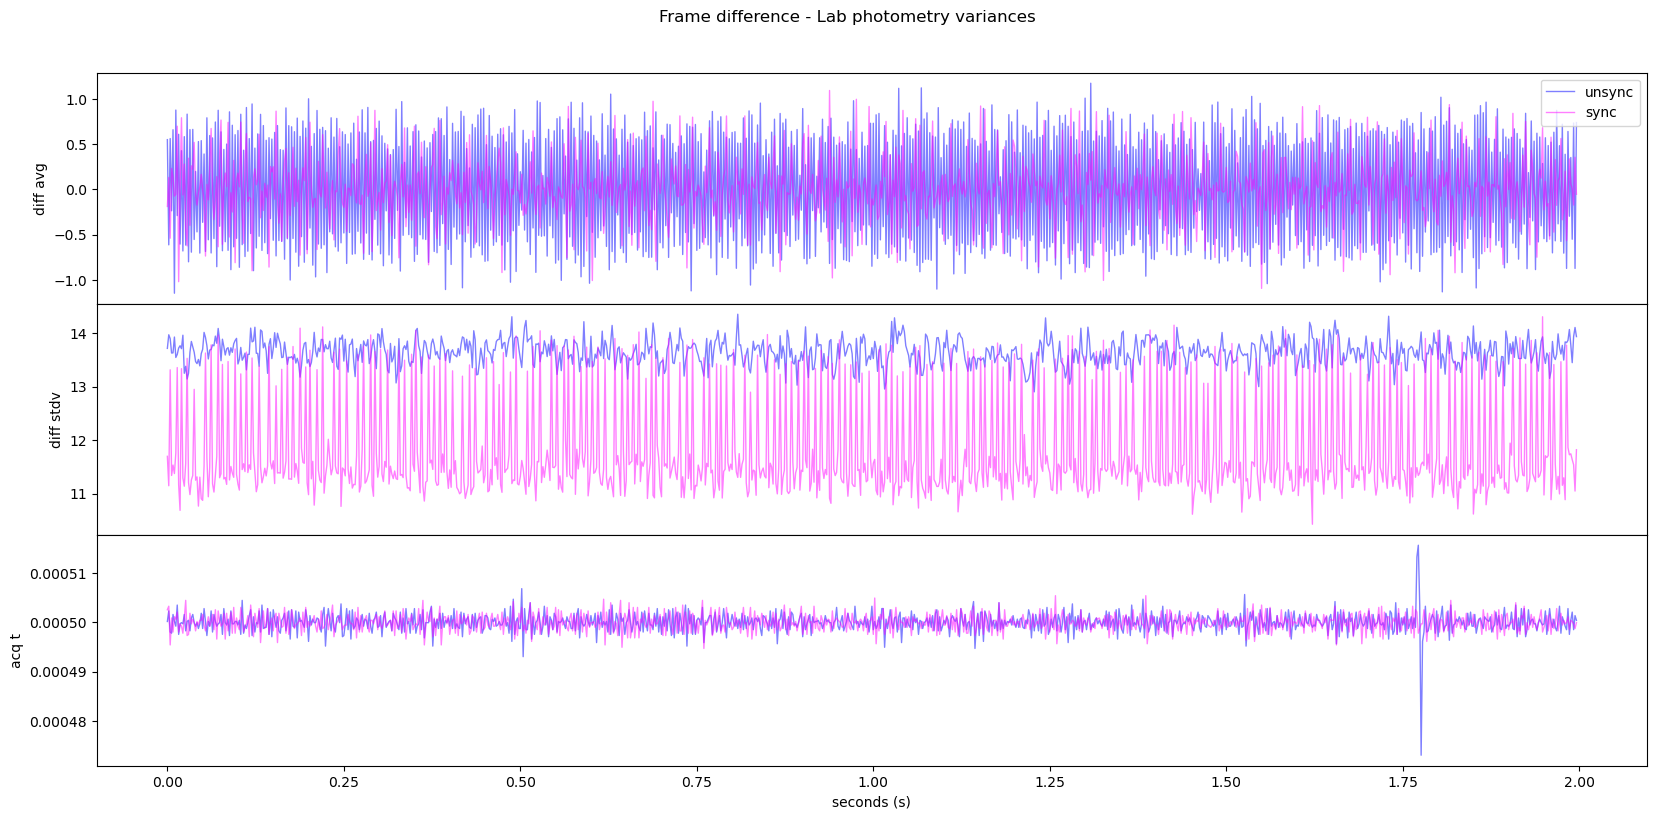

In [31]:
# Difference values
 
# Plotting the time series
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,9), facecolor='white', sharex=True)
fig.subplots_adjust(wspace=0, hspace = 0)
axs[0].set_ylabel("diff avg")
axs[0].plot(x_axis[:-1], unsync_d_avg, linewidth=1.0, c='blue', alpha=0.5, label = 'unsync')
axs[0].plot(x_axis[:-1], sync_d_avg, linewidth=1.0, c='magenta', alpha=0.5, label = 'sync')
axs[0].legend()

axs[1].set_ylabel("diff stdv")
axs[1].plot(x_axis[:-1], unsync_d_std, linewidth=1.0, c='blue', alpha = 0.5)
axs[1].plot(x_axis[:-1], sync_d_std, linewidth=1.0, c='magenta', alpha = 0.5)

axs[2].set_ylabel("acq t")
axs[2].plot(x_axis[:-1], unsync_acq_diff, linewidth=1.0, c='blue', alpha=0.5)
axs[2].plot(x_axis[:-1], sync_acq_diff, linewidth=1.0, c='magenta', alpha=0.5)
#axs[2].set_ylim(bottom=0, top=5.5e-4)

plt.xlabel('seconds (s)')
fig.suptitle("Frame difference - Lab photometry variances", y = 0.95)
plt.show()

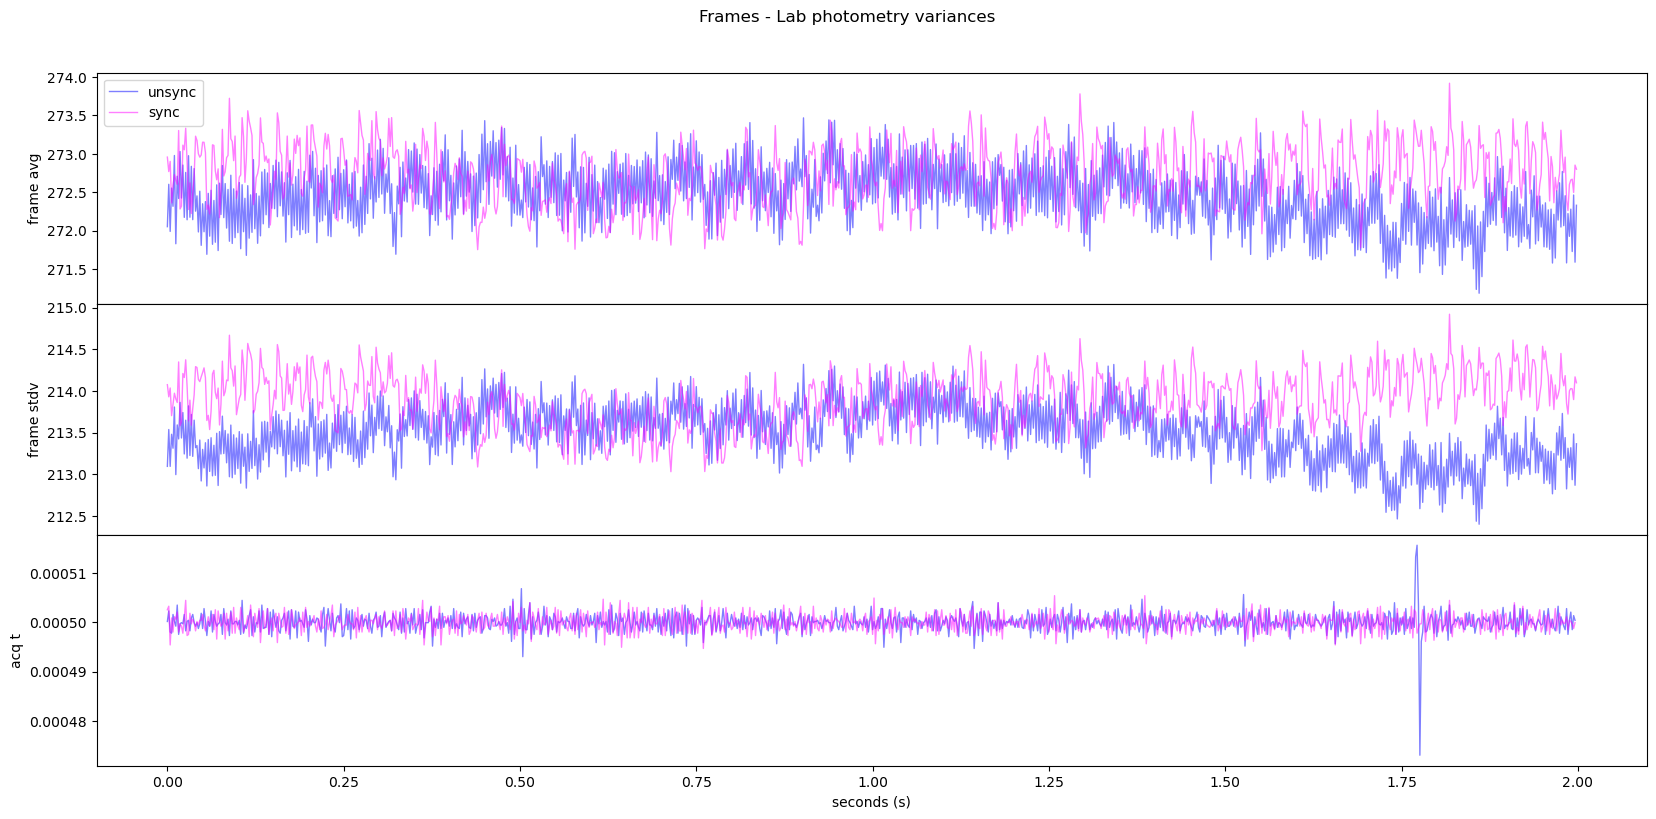

In [32]:
# Frame values
 
# Plotting the time series
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,9), facecolor='white', sharex=True)
fig.subplots_adjust(wspace=0, hspace = 0)
axs[0].set_ylabel("frame avg")
axs[0].plot(x_axis, unsync_f_avg, linewidth=1.0, c='blue', alpha=0.5, label = 'unsync')
axs[0].plot(x_axis, sync_f_avg, linewidth=1.0, c='magenta', alpha=0.5, label = 'sync')
axs[0].legend()

axs[1].set_ylabel("frame stdv")
axs[1].plot(x_axis, unsync_f_std, linewidth=1.0, c='blue', alpha = 0.5)
axs[1].plot(x_axis, sync_f_std, linewidth=1.0, c='magenta', alpha = 0.5)

axs[2].set_ylabel("acq t")
axs[2].plot(x_axis[:-1], unsync_acq_diff, linewidth=1.0, c='blue', alpha=0.5)
axs[2].plot(x_axis[:-1], sync_acq_diff, linewidth=1.0, c='magenta', alpha=0.5)
#axs[2].set_ylim(bottom=0, top=5.5e-4)

plt.xlabel('seconds (s)')
fig.suptitle("Frames - Lab photometry variances", y = 0.95)
plt.show()

## NEW: Check photometery counts

In [12]:
# List the photometry files
sync_phot_n = "2024-01-17_224857_sync_photometry_ND"
sync_phot_dir = lab_dir + sync_phot_n + "/camwfs/"
unsync_phot_n = "2024-01-17_223727_unsync_photometry_ND"
unsync_phot_dir = lab_dir + unsync_phot_n + "/camwfs/"

### SYNC redo

In [13]:
# trying the new parallelized reduction
sync_results = phot_count_pool(sync_phot_dir, 2000, 10)
sync_result_stk = np.hstack(np.array(sync_results))

processing from file 0 to 80000, Chunk size 8000 for 10 tasks
chunksize=3, n_workers=4


In [14]:
# covert x axis from frames to seconds
hz = 2000
frame_n = len(sync_result_stk[1])
total_s = 4*frame_n/hz
x_axis = np.arange(0, total_s, total_s/frame_n)

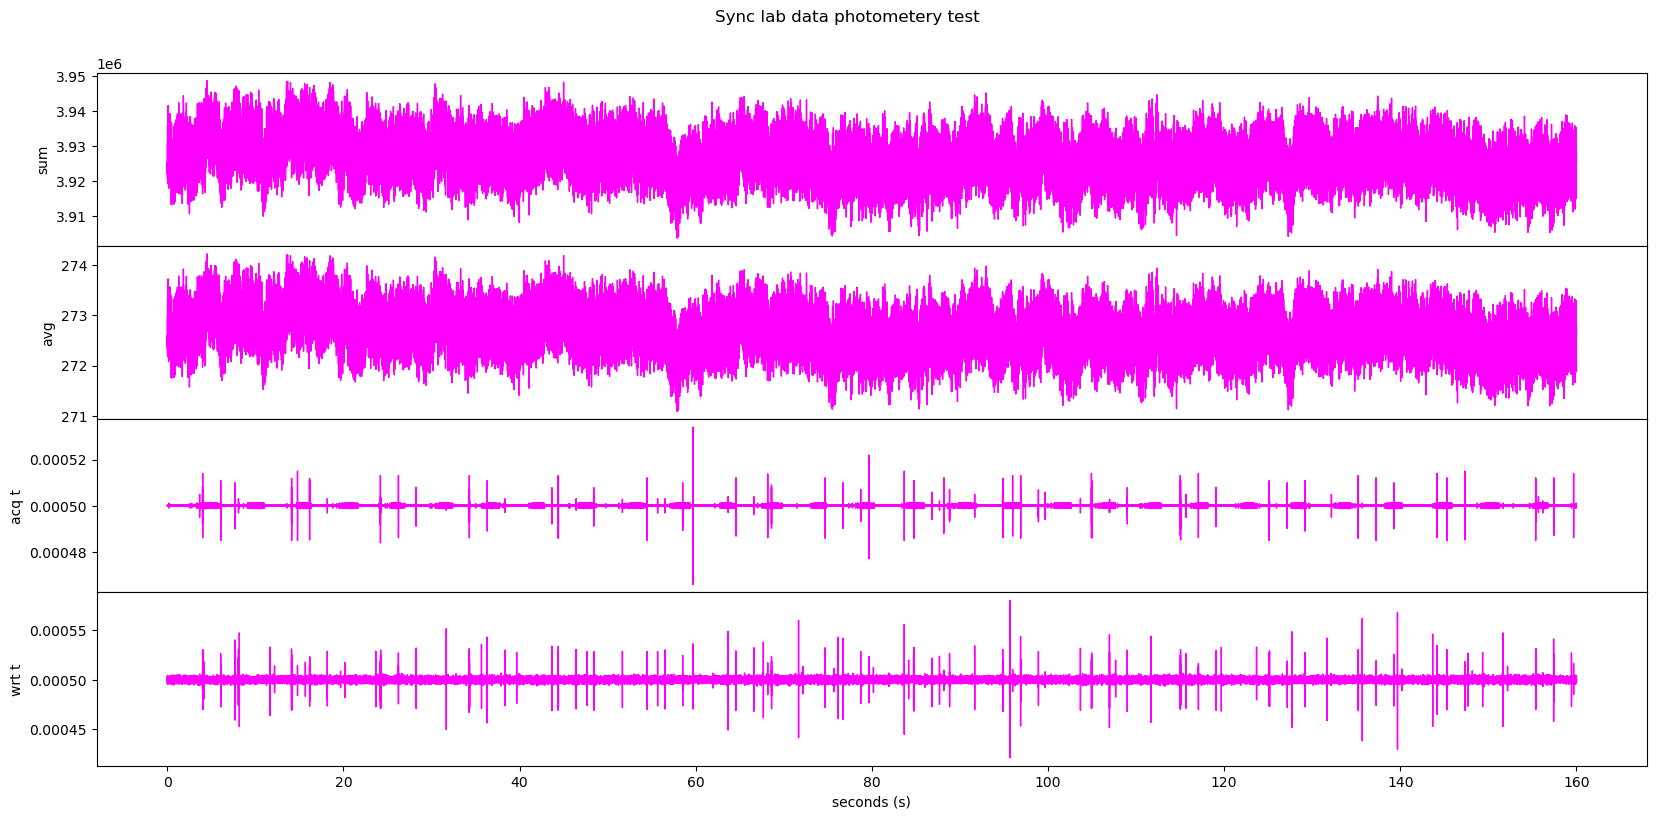

In [15]:
# Plotting the time series
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20,9), facecolor='white', sharex=True)
fig.subplots_adjust(wspace=0, hspace = 0)
axs[0].set_ylabel("sum")
axs[0].plot(x_axis, sync_result_stk[1], linewidth=1.0, c='magenta')
axs[1].set_ylabel("avg")
axs[1].plot(x_axis, sync_result_stk[0], linewidth=1.0, c='magenta')
axs[2].set_ylabel("acq t")
axs[2].plot(x_axis[:-1], sync_result_stk[3, 1:] - sync_result_stk[3, :-1], linewidth=1.0, c='magenta')
axs[3].set_ylabel("wrt t")
axs[3].plot(x_axis[:-1], sync_result_stk[2, 1:] - sync_result_stk[2, :-1], linewidth=1.0, c='magenta')

plt.xlabel('seconds (s)')
fig.suptitle("Sync lab data photometery test", y = 0.95)
plt.show()

### UNsync redo

In [7]:
unsync_results = phot_count_pool(unsync_phot_dir, 2000, 10)
unsync_result_stk = np.hstack(np.array(unsync_results))

processing from file 0 to 80000, Chunk size 8000 for 10 tasks
chunksize=3, n_workers=4


In [9]:
# covert x axis from frames to seconds
hz = 2000
frame_n = len(unsync_result_stk[1])
total_s = 4*frame_n/hz
x_axis = np.arange(0, total_s, total_s/frame_n)

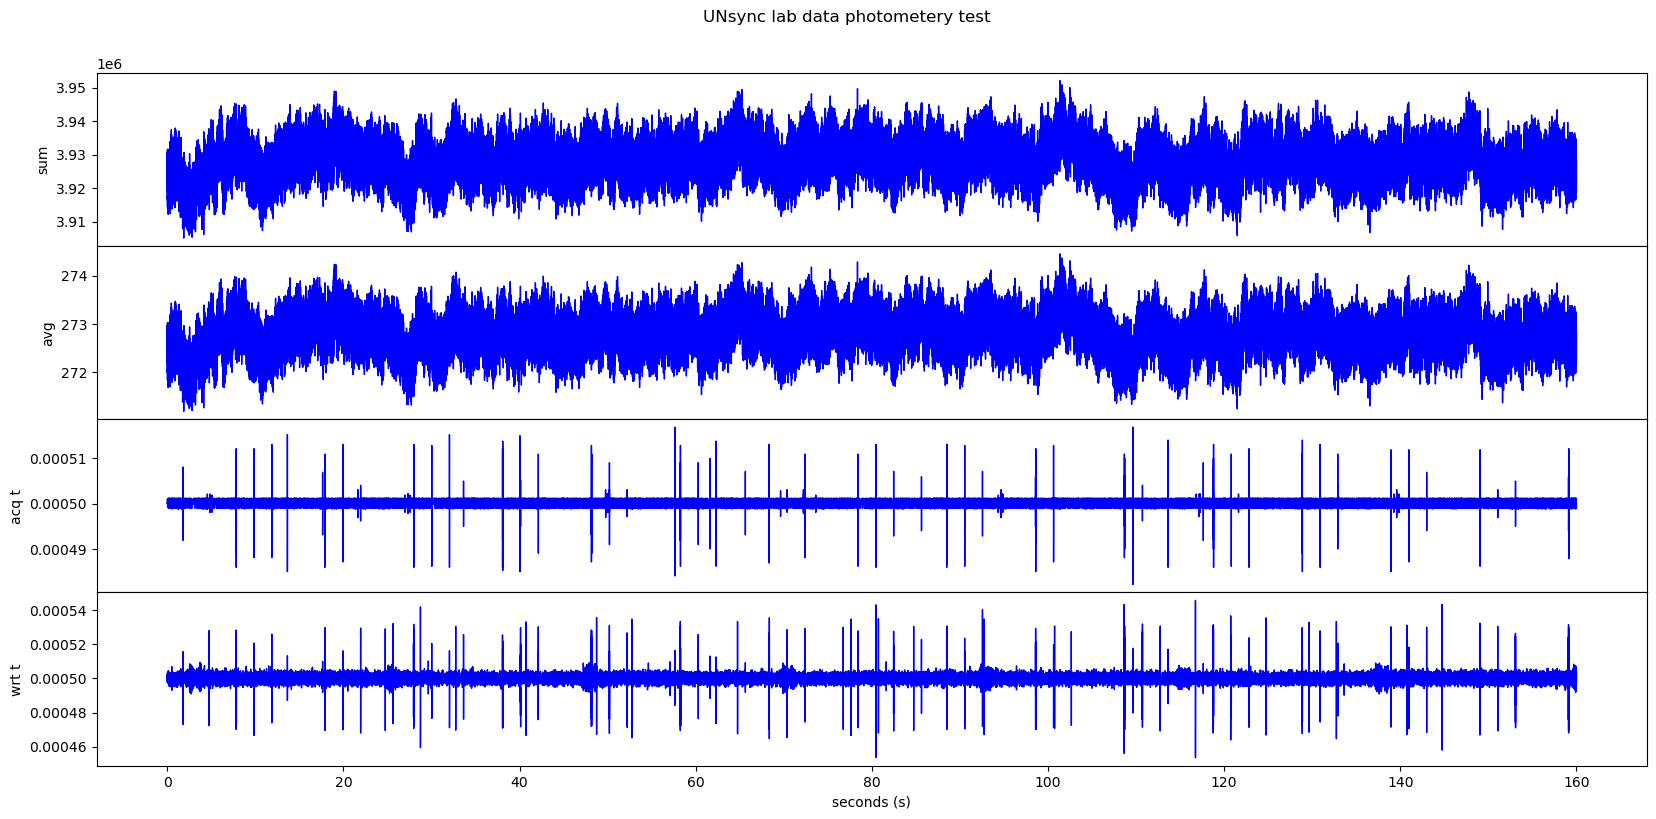

In [11]:
# Plotting the time series
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20,9), facecolor='white', sharex=True)
fig.subplots_adjust(wspace=0, hspace = 0)
axs[0].set_ylabel("sum")
axs[0].plot(x_axis, unsync_result_stk[1], linewidth=1.0, c='blue')
axs[1].set_ylabel("avg")
axs[1].plot(x_axis, unsync_result_stk[0], linewidth=1.0, c='blue')
axs[2].set_ylabel("acq t")
axs[2].plot(x_axis[:-1], unsync_result_stk[3, 1:] - unsync_result_stk[3, :-1], linewidth=1.0, c='blue')
axs[3].set_ylabel("wrt t")
axs[3].plot(x_axis[:-1], unsync_result_stk[2, 1:] - unsync_result_stk[2, :-1], linewidth=1.0, c='blue')

plt.xlabel('seconds (s)')
fig.suptitle("UNsync lab data photometery test", y = 0.95)
plt.show()

### compare

In [ ]:
unsync_acq = unsync_result_stk[3, 1:] - unsync_result_stk[3, :-1]
unsync_wrt = unsync_result_stk[2, 1:] - unsync_result_stk[2, :-1]
sync_acq = sync_result_stk[3, 1:] - sync_result_stk[3, :-1]
sync_wrt = sync_result_stk[2, 1:] - sync_result_stk[2, :-1]

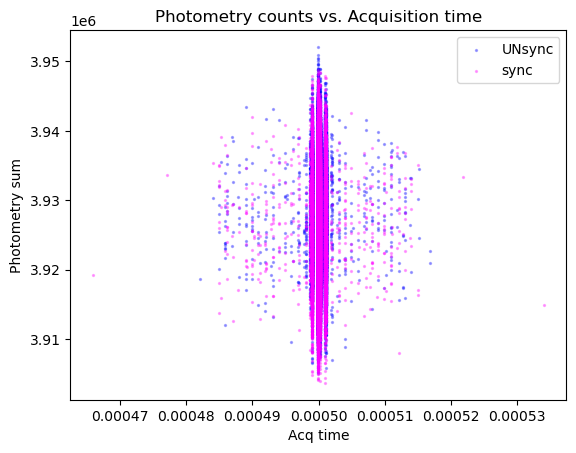

In [17]:
plt.title("Photometry counts vs. Acquisition time")
plt.scatter(unsync_acq, unsync_result_stk[1, :-1], alpha=0.3, s = 2, label="UNsync", color='blue')
plt.scatter(sync_acq, sync_result_stk[1, :-1], alpha=0.3, s = 2, label="sync", color='magenta')
plt.xlabel("Acq time")
plt.ylabel("Photometry sum")
plt.legend()
plt.show()

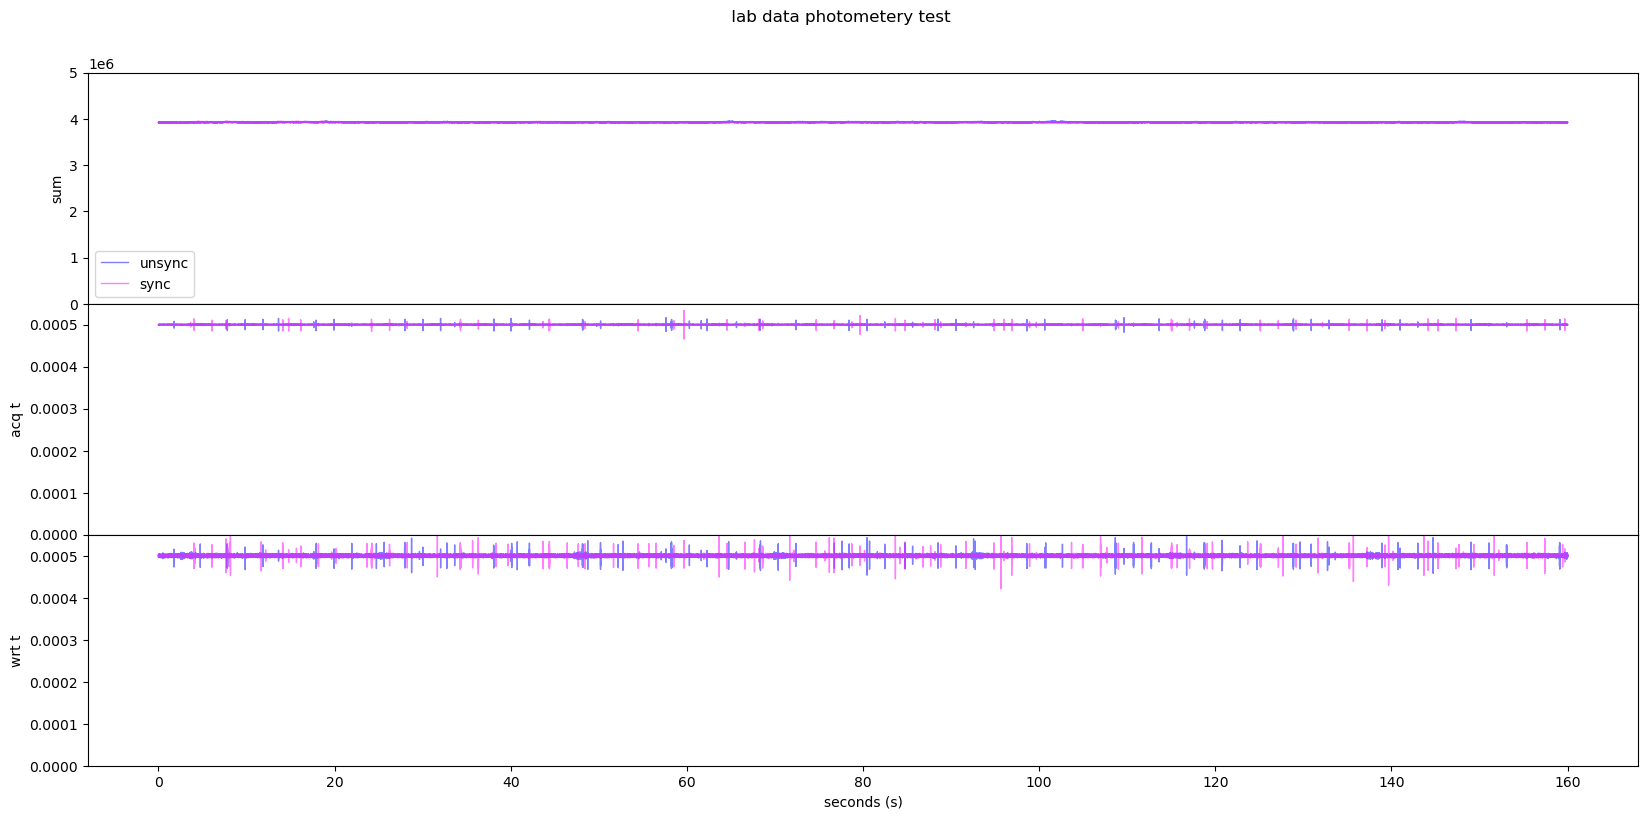

In [28]:
# Plotting the time series
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,9), facecolor='white', sharex=True)
fig.subplots_adjust(wspace=0, hspace = 0)
axs[0].set_ylabel("sum")
axs[0].plot(x_axis, unsync_result_stk[1], linewidth=1.0, c='blue', alpha=0.5, label = 'unsync')
axs[0].plot(x_axis, sync_result_stk[1], linewidth=1.0, c='magenta', alpha=0.5, label = 'sync')
axs[0].legend()
axs[0].set_ylim(bottom=0, top=5e6)

axs[1].set_ylabel("acq t")
axs[1].plot(x_axis[:-1], unsync_acq, linewidth=1.0, c='blue', alpha = 0.5)
axs[1].plot(x_axis[:-1], sync_acq, linewidth=1.0, c='magenta', alpha = 0.5)
axs[1].set_ylim(bottom=0, top =5.5e-4)

axs[2].set_ylabel("wrt t")
axs[2].plot(x_axis[:-1], unsync_wrt, linewidth=1.0, c='blue', alpha=0.5)
axs[2].plot(x_axis[:-1], sync_wrt, linewidth=1.0, c='magenta', alpha=0.5)
axs[2].set_ylim(bottom=0, top=5.5e-4)

plt.xlabel('seconds (s)')
fig.suptitle(" lab data photometery test", y = 0.95)
plt.show()

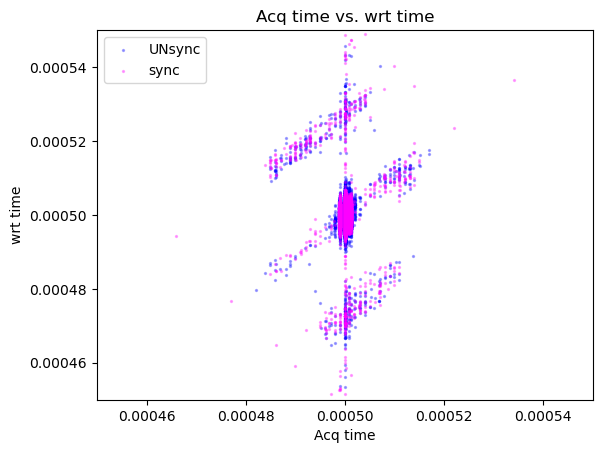

In [34]:
plt.title("Acq time vs. wrt time")
plt.scatter(unsync_acq, unsync_wrt, alpha=0.3, s = 2, label="UNsync", color='blue')
plt.scatter(sync_acq, sync_wrt, alpha=0.3, s = 2, label="sync", color='magenta')
plt.xlabel("Acq time")
plt.ylabel("wrt time")
plt.ylim(4.5e-4, 5.5e-4)
plt.xlim(4.5e-4, 5.5e-4)
plt.legend()
plt.show()

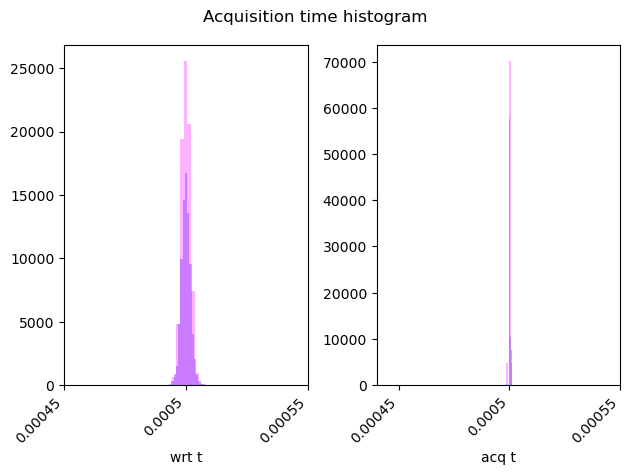

In [58]:
# ploting the histograms
n_bins = 100

fig, axs = plt.subplots(1, 2, tight_layout=True)
fig.suptitle("Acquisition time histogram")
axs[0].set_xlabel("wrt t")
axs[0].hist(unsync_result_stk[2, 1:] - unsync_result_stk[2, :-1], bins=n_bins, label="UNsync", color='blue', alpha = 0.3)
axs[0].hist(sync_result_stk[2, 1:] - sync_result_stk[2, :-1], bins=n_bins, label="sync", color='magenta', alpha=0.3)
axs[0].set_xlim(4.5e-4, 5.5e-4)
axs[0].set_xticks(np.arange(4.5e-4, 5.5e-4, 0.5e-4))
axs[0].set_xticklabels(np.arange(4.5e-4, 5.5e-4, 0.5e-4), rotation=45, ha='right')

axs[1].set_xlabel("acq t")
axs[1].hist(unsync_result_stk[3, 1:] - unsync_result_stk[3, :-1], bins=n_bins, label="UNsync", color='blue', alpha=0.3)
axs[1].hist(sync_result_stk[3, 1:] - sync_result_stk[3, :-1], bins=n_bins, label="sync", color='magenta', alpha=0.3)
axs[1].set_xlim(4.4e-4, 5.5e-4)
axs[1].set_xticks(np.arange(4.5e-4, 5.5e-4, 0.5e-4))
axs[1].set_xticklabels(np.arange(4.5e-4, 5.5e-4, 0.5e-4), rotation=45, ha='right')

plt.show()

## OLD: Checking Photometry Counts

In [54]:
# List the photometry files
sync_phot_n = "sync_photometry_20240112"
sync_phot_dir = lab_dir + sync_phot_n + "/camwfs/"
unsync_phot_n = "unsync_photometry_20240112"
unsync_phot_dir = lab_dir + unsync_phot_n + "/camwfs/"

In [49]:
# pull file, count max, average, sum 
f_dir = sync_phot_dir
## ^ change this

sync_avg = []
sync_sum = []
sync_wrt = []

file_list = spkl.file_lister(f_dir)

### SYNC photometry

In [6]:
# pull file, count max, average, sum 
f_dir = sync_phot_dir
## ^ change this

sync_avg = []
sync_sum = []
sync_wrt = []

file_list = spkl.file_lister(f_dir)
# go through all the files
for f in file_list:
    with fits.open(f_dir + f) as hdul:
        f_data = hdul[0].data
        wrt = hdul[0].header['WRTSEC'] + hdul[0].header['WRTNSEC']*10**(-9)
        f_data_masked = f_data*mask_data
        sync_avg.append(np.mean(f_data_masked))
        sync_sum.append(np.sum(f_data_masked))
        sync_wrt.append(wrt)

In [9]:
np.save("sync_phot_sum.npy", np.array(sync_sum))
np.save("sync_phot_avg.npy", np.array(sync_avg))
np.save("sync_phot_wrt.npy", np.array(sync_wrt))

In [15]:
# chalculate the differences in the write times
sync_wrt = np.array(sync_wrt)
sync_wrt_t = sync_wrt[1:] - sync_wrt[:-1]

In [41]:
# covert x axis from frames to seconds
hz = 2000
frame_n = len(sync_sum)
total_s = 4*frame_n/hz
x_axis = np.arange(0, total_s, total_s/frame_n)

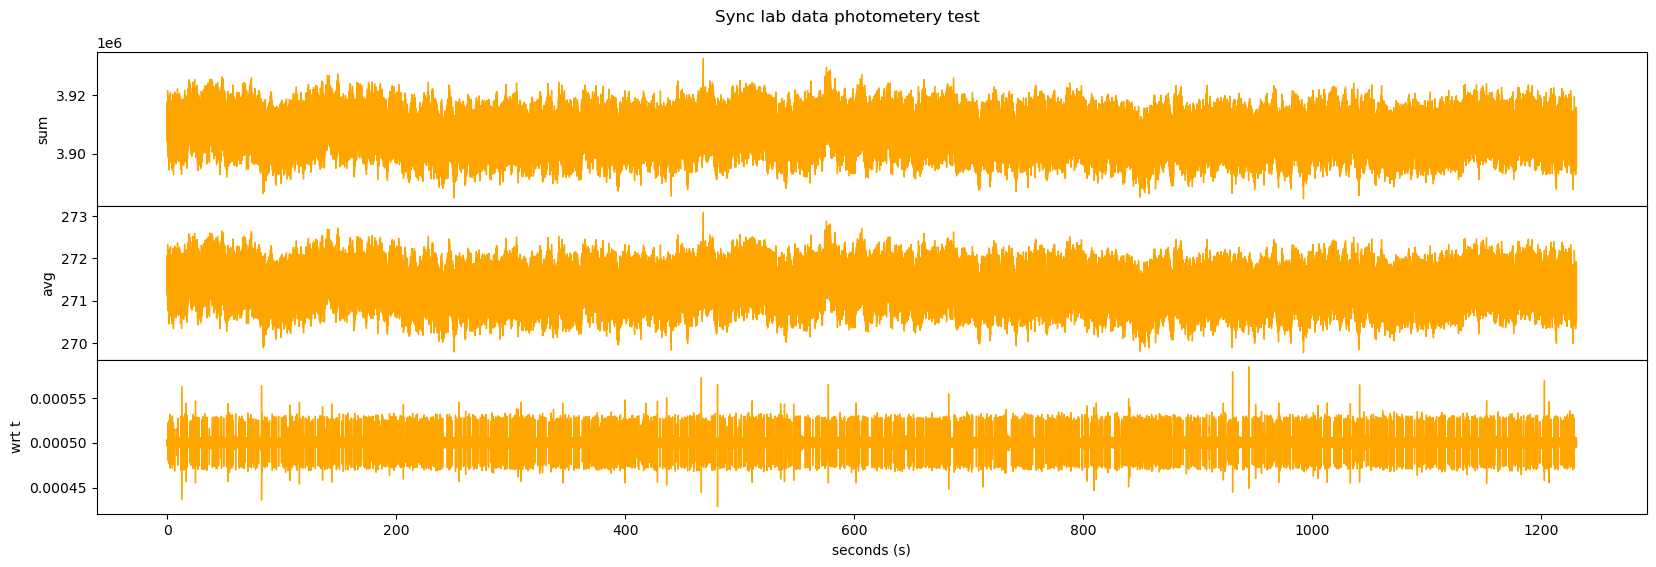

In [43]:
# Plotting the time series
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,6), facecolor='white', sharex=True)
fig.subplots_adjust(wspace=0, hspace = 0)
axs[0].set_ylabel("sum")
axs[0].plot(x_axis, sync_sum, linewidth=1.0, c='orange')
axs[1].set_ylabel("avg")
axs[1].plot(x_axis, sync_avg, linewidth=1.0, c='orange')
axs[2].set_ylabel("wrt t")
axs[2].plot(x_axis[:-1], sync_wrt_t, linewidth=1.0, c='orange')

plt.xlabel('seconds (s)')
fig.suptitle("Sync lab data photometery test", y = 0.95)
plt.show()

### UNSYNC Photometry

In [25]:
# pull file, count max, average, sum 
f_dir = unsync_phot_dir
## ^ change this

unsync_avg = []
unsync_sum = []
unsync_wrt = []

file_list = spkl.file_lister(f_dir)
# go through all the files
print(f"{len(file_list)} files in Directory {f_dir}")
for e, f in enumerate(file_list):
    with fits.open(f_dir + f) as hdul:
        f_data = hdul[0].data
        wrt = hdul[0].header['WRTSEC'] + hdul[0].header['WRTNSEC']*10**(-9)
        f_data_masked = f_data*mask_data
        unsync_avg.append(np.mean(f_data_masked))
        unsync_sum.append(np.sum(f_data_masked))
        unsync_wrt.append(wrt)
    if e%1000 == 0:
            print(f"On file {e} of {len(file_list)}")

552681 files in Directory /home/eden/data/LAB_2023B/unsync_photometry_20240112/camwfs/
On file 0 of 552681
On file 1000 of 552681
On file 2000 of 552681
On file 3000 of 552681
On file 4000 of 552681
On file 5000 of 552681
On file 6000 of 552681
On file 7000 of 552681
On file 8000 of 552681
On file 9000 of 552681
On file 10000 of 552681
On file 11000 of 552681
On file 12000 of 552681
On file 13000 of 552681
On file 14000 of 552681
On file 15000 of 552681
On file 16000 of 552681
On file 17000 of 552681
On file 18000 of 552681
On file 19000 of 552681
On file 20000 of 552681
On file 21000 of 552681
On file 22000 of 552681
On file 23000 of 552681
On file 24000 of 552681
On file 25000 of 552681
On file 26000 of 552681
On file 27000 of 552681
On file 28000 of 552681
On file 29000 of 552681
On file 30000 of 552681
On file 31000 of 552681
On file 32000 of 552681
On file 33000 of 552681
On file 34000 of 552681
On file 35000 of 552681
On file 36000 of 552681
On file 37000 of 552681
On file 38000 

In [26]:
np.save("unsync_phot_sum.npy", np.array(unsync_sum))
np.save("unsync_phot_avg.npy", np.array(unsync_avg))
np.save("unsync_phot_wrt.npy", np.array(unsync_wrt))

In [27]:
# chalculate the differences in the write times
unsync_wrt = np.array(unsync_wrt)
unsync_wrt_t = unsync_wrt[1:] - unsync_wrt[:-1]

In [28]:
# covert x axis from frames to seconds
hz = 2000
frame_n = len(unsync_sum)
total_s = 4*frame_n/hz
x_axis = np.arange(0, total_s, total_s/frame_n)

ValueError: x and y must have same first dimension, but have shapes (615367,) and (552681,)

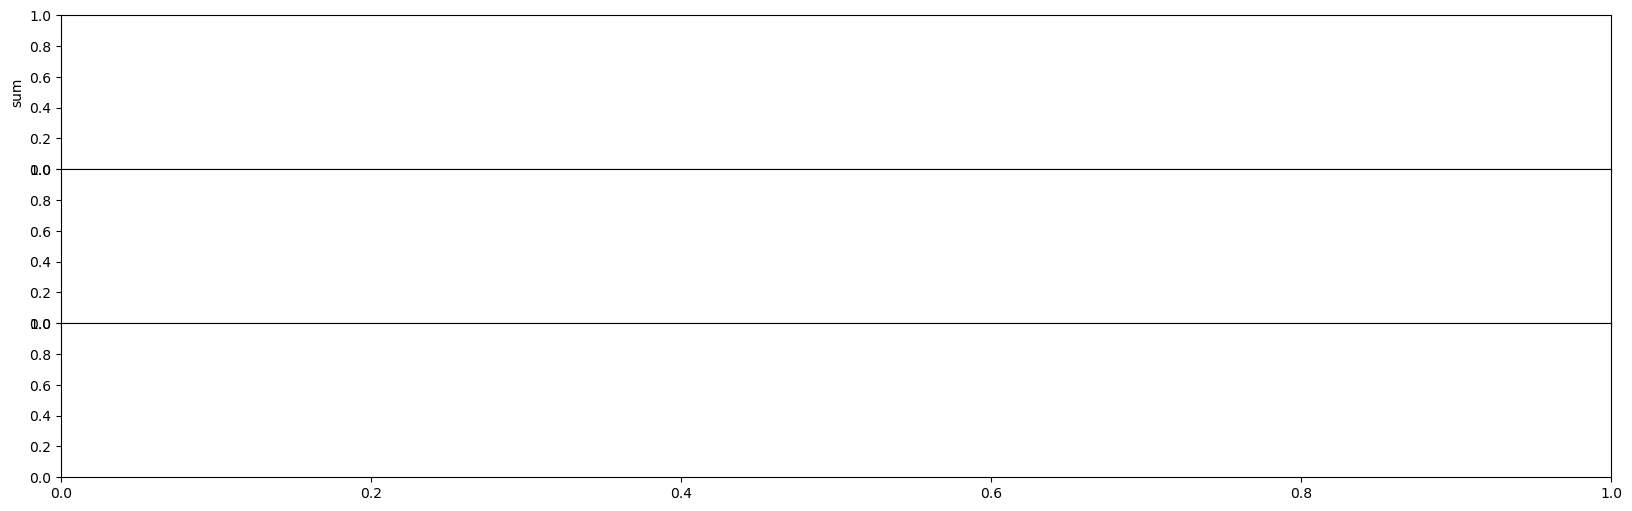

In [45]:
# Plotting the time series
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,6), facecolor='white', sharex=True)
fig.subplots_adjust(wspace=0, hspace = 0)
axs[0].set_ylabel("sum")
axs[0].plot(x_axis, unsync_sum, linewidth=1.0, alpha = 0.5)
axs[1].set_ylabel("avg")
axs[1].plot(x_axis, unsync_avg,linewidth=1.0)
axs[2].set_ylabel("wrt t")
axs[2].plot(x_axis, unsync_wrt, linewidth=1.0)

plt.xlabel('seconds (s)')
fig.suptitle("UNsync lab data photometery test", y = 0.95)
plt.show()

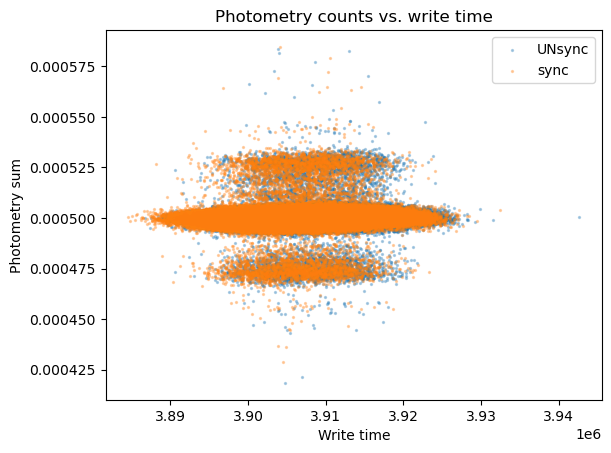

In [39]:
plt.title("Photometry counts vs. write time")
plt.scatter(unsync_sum[:-1], unsync_wrt_t, alpha=0.3, s = 2, label="UNsync")
plt.scatter(sync_sum[:-1], sync_wrt_t, alpha=0.3, s = 2, label="sync")
plt.xlabel("Write time")
plt.ylabel("Photometry sum")
plt.legend()
plt.show()

## IF have time, can make this a more robust paralellized function

In [55]:
from multiprocessing import Pool
from functools import partial
from math import ceil

def phot_count_pool(f_dir, chunk_size, n_chunks, n_start=0, n_workers=4):
    """ dot files in chunks, in parallelism """
    f_list = spkl.file_lister(f_dir) # just for checking length
    # check the end number 
    # number of tasks to execute
    n_end = n_start + chunk_size*4*n_chunks
    n_tasks = int((n_end - n_start) / (chunk_size*4))
    print(f"processing from file {n_start} to {n_end}, Chunk size {chunk_size*4} for {n_tasks} tasks")
    #creating the list of n_starts
    n_start_list = [n_start + n*chunk_size*4 for n in range(n_tasks)]
    # create the multiprocessing pool
    with Pool(processes=n_workers) as pool:
        # chunksize to use
        n_tasks_per_chunk = ceil(n_tasks / len(pool._pool))
        # report details for reference
        print(f'chunksize={n_tasks_per_chunk}, n_workers={len(pool._pool)}')
        # issue tasks and process results
        results = pool.map(partial(phot_file, path=f_dir), n_start_list, chunksize=n_tasks_per_chunk)
    # return the dot products:
    dot_results = results
    return dot_results

def phot_file(file, path):
    with fits.open(path + file) as hdul:
        f_data = hdul[0].data
        wrt = hdul[0].header['WRTSEC'] + hdul[0].header['WRTNSEC']*10**(-9)
        acq = hdul[0].header['ACQSEC'] + hdul[0].header['ACQNSEC']*10**(-9)
        f_data_masked = f_data*mask_data
        f_avg = np.mean(f_data_masked)
        f_sum = np.sum(f_data_masked)
    return f_avg, f_sum, wrt, acq